In [1]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer

## Sk learn imports
from sklearn.linear_model import LogisticRegression, Ridge

## contextualbandit package
from contextualbandits.online import SeparateClassifiers
from contextualbandits.offpolicy import OffsetTree
from contextualbandits.offpolicy import DoublyRobustEstimator

## Plotting
import matplotlib.pyplot as plt, pandas as pd
import seaborn as sns

from tqdm import tqdm
import random
import math


from matplotlib import pyplot as plt
from matplotlib.pyplot import ylim
from matplotlib.pyplot import figure

%matplotlib inline
import mmap

In [2]:
def get_num_lines(file_path):
    """Gets the number of lines that exists in the file in the provided filepath
    
    :param file_path: A string that provides the file path of the file that needs its lines counted.
    :type file_path: string, required
    
    :return: The number of lines in the file
    :rtype: int
    """
    fp = open(file_path, "r+")
    buf = mmap.mmap(fp.fileno(), 0)
    lines = 0
    while buf.readline():
        lines += 1
    return lines

In [3]:
def parse_data(filename):
    """Extracts the features and predictions from the provided file
    
    :param filename: A string that provides the file path of the file that needs its lines counted.
    :type filename: string, required
    
    :return: Tuple with the features and expected predictions of those features
    :rtype: Tuple containing a list of lists and a list of ints
    """
    feature_list = []
    preds = []
    with open(filename, "rb") as f:
        for line in tqdm(f, total=get_num_lines(filename)):
            line = line.decode('ASCII').strip()
            features = line.split(',')
            preds.append(features[0])
            features = features[1:]
            feature_list.append(features)
    return feature_list, preds

features, preds = parse_data("datasets/CNAE-9.data")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1080/1080 [00:00<00:00, 60044.12it/s]


In [4]:
def clean_data(features, preds):
    """Cleans the provided features and predictions
    
    :param features: A list of features
    :type features: list, required
    
    :param preds: A list of expected predictions
    :type preds: list, required
    
    :return: Tuple with the cleaned features and expected predictions of those features
    :rtype: Tuple containing a numpy array of numpy arrays of ints and a numpy array  of ints
    """
    mlb = MultiLabelBinarizer()
    preds_list = [[i] for i in preds]
    preds_mlb = mlb.fit_transform(preds_list)
    features = np.array(features)

    temp = list(zip(features, preds_mlb))
    random.shuffle(temp)
    features, preds_mlb = zip(*temp)

    features = np.array(features).astype(int)
    preds_mlb = np.array(preds_mlb)
    return features, preds_mlb

features, y = clean_data(features, preds)


In [20]:
get_num_lines("datasets/CNAE-9.data")

1080

Test set mean reward - Separate Classifiers:  0.11896551724137931
Test set mean reward - Separate Classifiers + Prior:  0.3413793103448276
Test set mean reward - Separate Classifiers + Smoothing:  0.11206896551724138
Test set mean reward - Offset Tree technique:  0.9206896551724137
Test set mean reward - Doubly-Robust Estimator:  0.8827586206896552
Test set mean reward - Doubly-Robust Estimator + Prior:  0.8827586206896552
Test set mean reward - Doubly-Robust Estimator + Smoothing:  0.8741379310344828


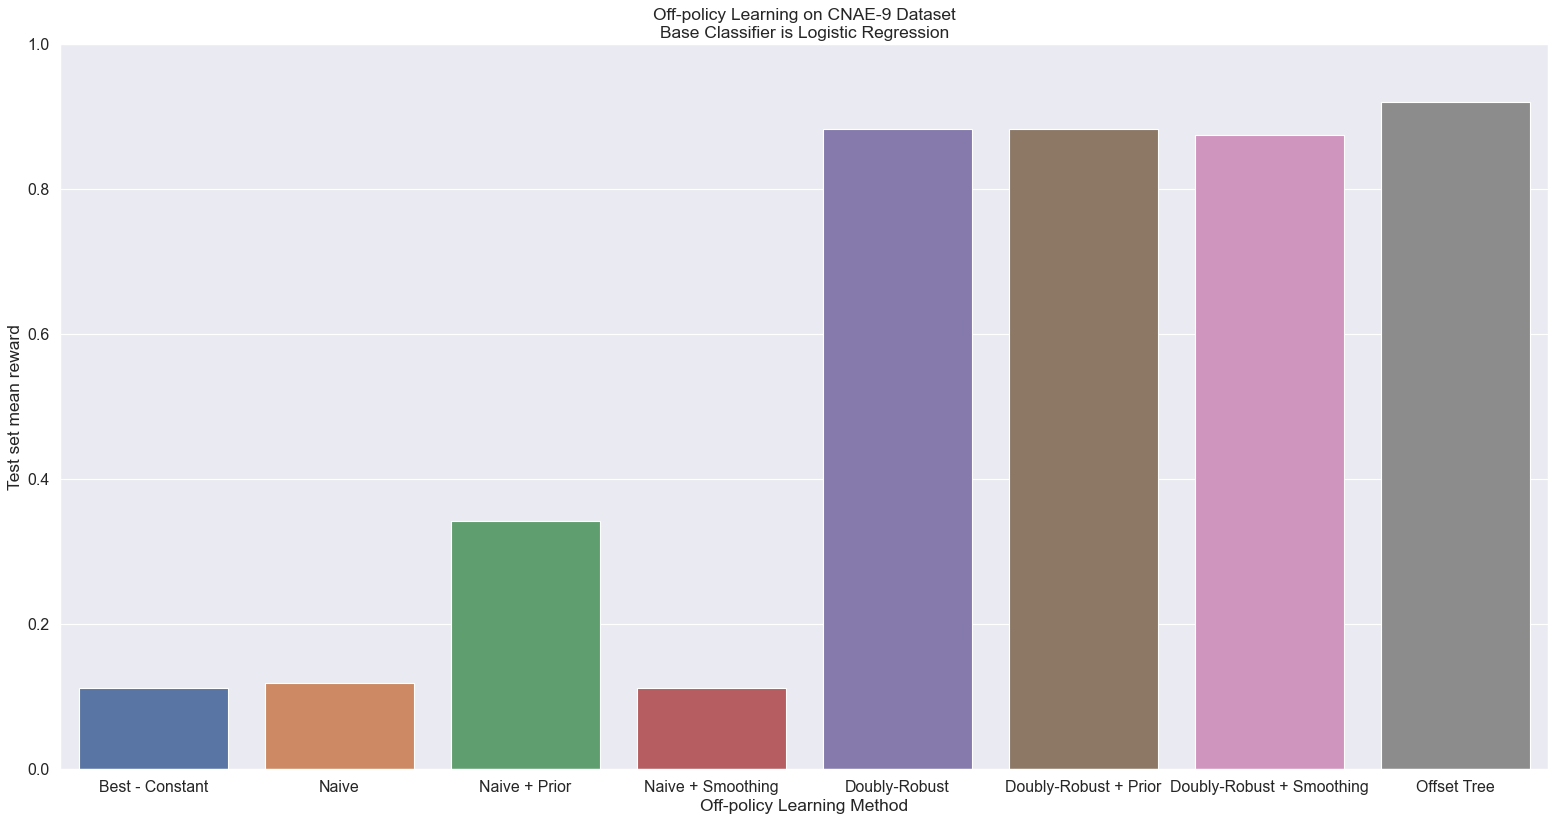

In [21]:
def CMAB_explore(features, y):
    """Explores the viablity of various CMAB algorithms using the provided features and predictions.
       Once it is done exploring it plots out the results of the exploration in a graph for comparison
    
    :param features: A numpy array of features
    :type features: numpy array, required
    
    :param y: A numpy array of expected predictions
    :type y: numpy array, required
    """
    
    ## We can see that there are 1080 rows to  explore so we can split the data into an exploration set
    ## initial test set
    ## and then an off-policy set

    # the 'explorer' polcy will be fit with this small sample of the rows
    st_seed = 0
    end_seed = 200

    # then it will choose actions for this larger sample
    st_exploration = 0
    end_exploration = 500

    # the new policy will be evaluated with a separate test set
    st_test = 500
    end_test = 1080

    # separating the covariates data for each case
    Xseed = features[st_seed:end_seed, :]
    Xexplore_sample = features[st_exploration:end_exploration, :]
    Xtest = features[st_test:end_test, :]
    nchoices = y.shape[1]

    # now constructing an exploration policy as explained above, with fully-labeled data
    explorer = LogisticRegression(solver="sag", max_iter=15000)
    explorer.fit(Xseed, np.argmax(y[st_seed:end_seed], axis=1))

    # letting the exploration policy choose actions which will then be used new policy input
    actions_explore_sample = explorer.predict(Xexplore_sample)
    rewards_explore_sample = y[st_exploration:end_exploration, :]\
                            [np.arange(end_exploration - st_exploration), actions_explore_sample]

    # extracting the probabilities it estimated
    ix_internal_actions = {j:i for i,j in enumerate(explorer.classes_)}
    ix_internal_actions = [ix_internal_actions[i] for i in actions_explore_sample]
    ix_internal_actions = np.array(ix_internal_actions)
    prob_actions_explore = explorer.predict_proba(Xexplore_sample)[np.arange(Xexplore_sample.shape[0]),
                                                                   ix_internal_actions]
    new_policy = SeparateClassifiers(base_algorithm=LogisticRegression(solver="sag", max_iter=15000),
                                     nchoices=y.shape[1], beta_prior=None, smoothing=None)
    new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample)
    mean_reward_naive = np.mean(y[st_test:end_test, :]\
                                 [np.arange(end_test - st_test), new_policy.predict(Xtest)])
    print("Test set mean reward - Separate Classifiers: ", mean_reward_naive)
    new_policy = SeparateClassifiers(base_algorithm=LogisticRegression(solver="sag", max_iter=15000),
                                     nchoices=y.shape[1], beta_prior="auto")
    new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample)
    mean_reward_beta = np.mean(y[st_test:end_test, :]\
                                [np.arange(end_test - st_test), new_policy.predict(Xtest)])
    print("Test set mean reward - Separate Classifiers + Prior: ", mean_reward_beta)
    new_policy = SeparateClassifiers(base_algorithm=LogisticRegression(solver="sag", max_iter=15000),
                                     nchoices=y.shape[1], beta_prior=None, smoothing = (1,2))
    new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample)
    mean_reward_sm = np.mean(y[st_test:end_test, :]\
                                [np.arange(end_test - st_test), new_policy.predict(Xtest)])
    print("Test set mean reward - Separate Classifiers + Smoothing: ", mean_reward_sm)
    new_policy = OffsetTree(base_algorithm=LogisticRegression(solver="sag", max_iter=15000), nchoices=y.shape[1])
    new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
    mean_reward_ot = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
    print("Test set mean reward - Offset Tree technique: ", mean_reward_ot)
    new_policy = DoublyRobustEstimator(base_algorithm = Ridge(),
                                       reward_estimator = LogisticRegression(solver="sag", max_iter=15000),
                                       nchoices = y.shape[1],
                                       method = 'rovr', beta_prior = None, smoothing = None)
    new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
    mean_reward_dr = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
    print("Test set mean reward - Doubly-Robust Estimator: ", mean_reward_dr)
    new_policy = DoublyRobustEstimator(base_algorithm = Ridge(),
                                       reward_estimator = LogisticRegression(solver="sag", max_iter=15000),
                                       nchoices = y.shape[1],
                                       method = 'rovr', beta_prior = "auto", smoothing = None)
    new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
    mean_reward_dr_prior = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
    print("Test set mean reward - Doubly-Robust Estimator + Prior: ", mean_reward_dr_prior)
    new_policy = DoublyRobustEstimator(base_algorithm = Ridge(),
                                       reward_estimator = LogisticRegression(solver="sag", max_iter=15000),
                                       nchoices = y.shape[1],
                                       method = 'rovr', beta_prior = None, smoothing = (1, 2))
    new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
    mean_reward_dr_sm = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
    print("Test set mean reward - Doubly-Robust Estimator + Smoothing: ", mean_reward_dr_sm)
    results = pd.DataFrame({
        'Off-policy Learning Method' : ['Best - Constant', 'Naive', 'Naive + Prior', 'Naive + Smoothing', 'Doubly-Robust',
                                        'Doubly-Robust + Prior', 'Doubly-Robust + Smoothing', 'Offset Tree'],
        'Test set mean reward' : [mean_constant, mean_reward_naive, mean_reward_beta, mean_reward_sm, mean_reward_dr,
                                  mean_reward_dr_prior, mean_reward_dr_sm, mean_reward_ot]
    })
    figure(figsize=(24, 12), dpi=80)
    ylim(top=1) 
    sns.set(font_scale = 1.3)
    sns.barplot(x = "Off-policy Learning Method", y="Test set mean reward", data=results)
    plt.title('Off-policy Learning on CNAE-9 Dataset\nBase Classifier is Logistic Regression')
    plt.show()
    
CMAB_explore(features, y)

## Random selection of CNAE-9

In [22]:
def random_selection(y):
    """Explores the viablity of random selection for this dataset
    
    :param y: A numpy array of expected predictions
    :type y: numpy array, required
    
    :return: double that has the percentage of correct guesses
    :rtype: double
    """
    N = y.shape[0]
    d = y.shape[1]
    selected = []
    total_reward = 0
    rand_avgs = []

    for n in range(N):
        selection = random.randrange(d)
        selected.append(selection)
        reward = y[n][selection]
        total_reward += reward
        rand_average = total_reward/(n+1)
        rand_avgs.append(rand_average)
    return rand_avgs[-1]

random_selection(y)

0.1259259259259259

## Epsilon greedy

In [23]:
def E_greedy(y):
    """Explores the viablity of epsilon greedy selection for this dataset
    
    :param y: A numpy array of expected predictions
    :type y: numpy array, required
    
    :return: double that has the percentage of correct guesses
    :rtype: double
    """
    N = y.shape[0]
    d = y.shape[1]
    selected = []
    total_reward = 0  

    eps = 0.1
    average = [0] * d
    counts =  [0] * d
    rewards =  []

    epsilon_average = []

    for n in range(N):
        p = np.random.random()

        if p < eps:
            selection = np.random.choice(d)
        else:
            selection = np.argmax([a for a in average])

        reward = y[n][selection]
        total_reward += reward
        rewards.append(reward)
        average[selection] = (average[selection]*counts[selection] + reward)/(counts[selection] + 1)
        counts[selection] += 1

        e_average = total_reward/(n+1)
        epsilon_average.append(e_average)

    return epsilon_average[-1]

E_greedy(y)

0.10740740740740741

## UCB

In [25]:
def UCB(y):
    """Explores the viablity of UCB selection for this dataset
    
    :param y: A numpy array of expected predictions
    :type y: numpy array, required
    
    :return: double that has the percentage of correct guesses
    :rtype: double
    """
    N = y.shape[0]
    d = y.shape[1]
    selected = []
    total_reward = 0  

    UCB_averages = []

    numbers_of_selections = np.zeros(d)
    sums_of_reward = np.zeros(d)

    for n in range(N):
        max_upper_bound = 0
        ad = 0
        for i in range(0, d):
            if (numbers_of_selections[i] > 0):
                average_reward = sums_of_reward[i] / numbers_of_selections[i]
                delta_i = math.sqrt(2 * math.log(n+1) / numbers_of_selections[i])
                upper_bound = average_reward + delta_i
            else:
                upper_bound = 1e100
            if upper_bound > max_upper_bound:
                max_upper_bound = upper_bound
                selection = i
        selected.append(ad)
        numbers_of_selections[selection] += 1
        reward = y[n][selection]
        sums_of_reward[selection] += reward
        total_reward += reward
        average = total_reward/(n+1)
        UCB_averages.append(average)
    return UCB_averages[-1]
UCB(y)

0.12777777777777777

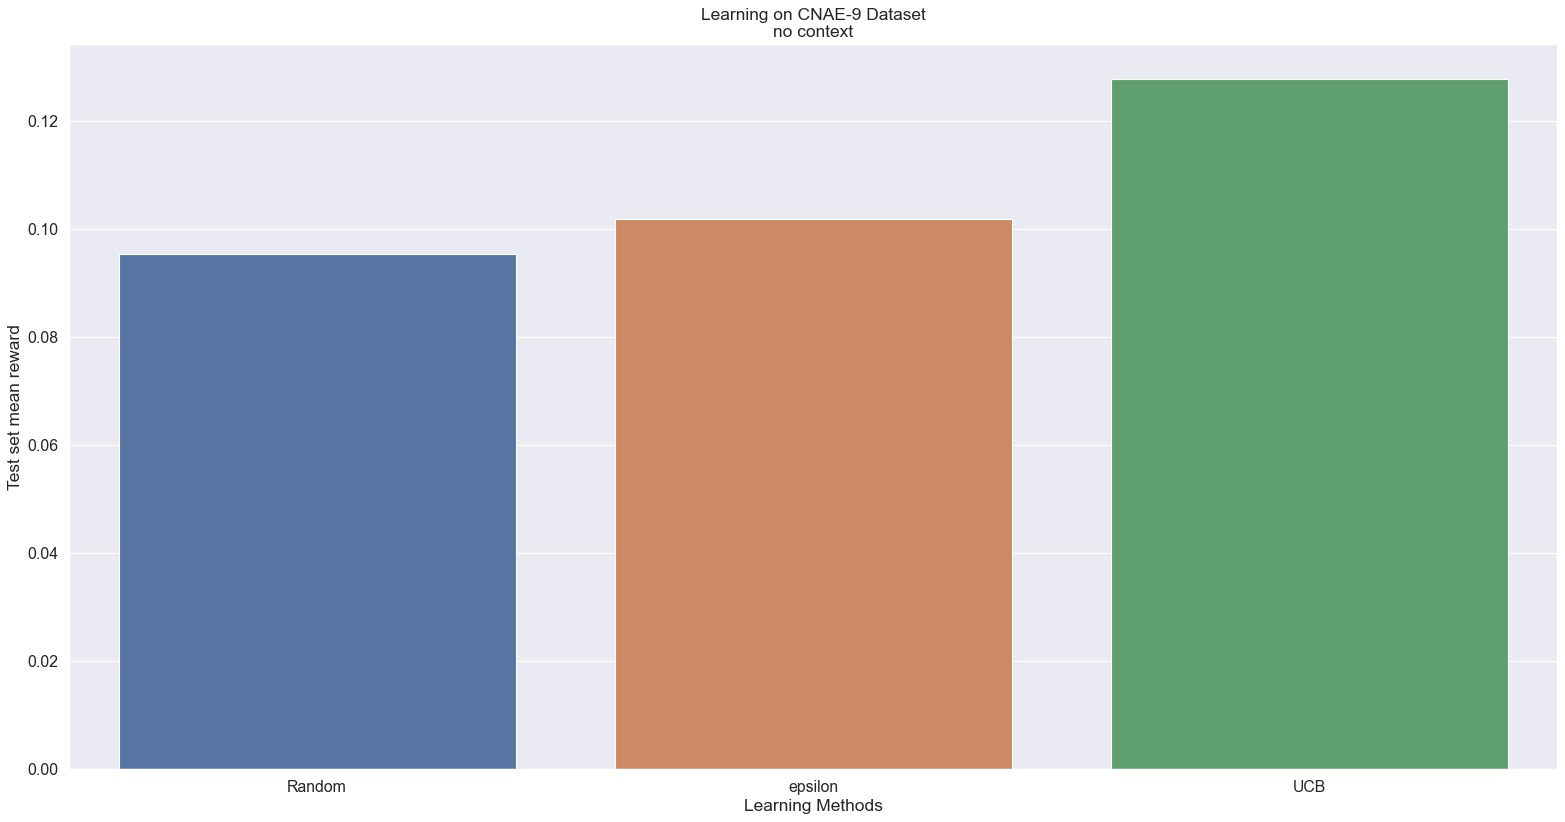

In [27]:
def compare(y):
    """Compares the viablity of MAB algorithms on this data set
    
    :param y: A numpy array of expected predictions
    :type y: numpy array, required
    """
    figure(figsize=(24, 12), dpi=80)
    results = pd.DataFrame({
        'Learning Methods' : ['Random', 'epsilon', 'UCB'],
        'Test set mean reward' : [random_selection(y), E_greedy(y), UCB(y)]
    })

    sns.set(font_scale = 1.3)
    sns.barplot(x = "Learning Methods", y="Test set mean reward", data=results)
    plt.title('Learning on CNAE-9 Dataset\nno context')
    plt.show()
compare(y)